[DATA SHAPES]
Train (raw): (500, 2)   Test0.1: (500, 2)   Test0.2: (500, 2)   Test0.3: (500, 2)
[CLASS BALANCE - Train]: [250 250]

[STANDARDIZATION]
Train mean (approx 0): [-0.  0.]
Train std  (approx 1): [1. 1.]

[SPLIT]
X_train: (400, 2)  y_train: (400,)
X_val  : (100, 2)  y_val  : (100,)
[CLASS BALANCE - Train split]: [200 200]
[CLASS BALANCE - Val split]  : [50 50]


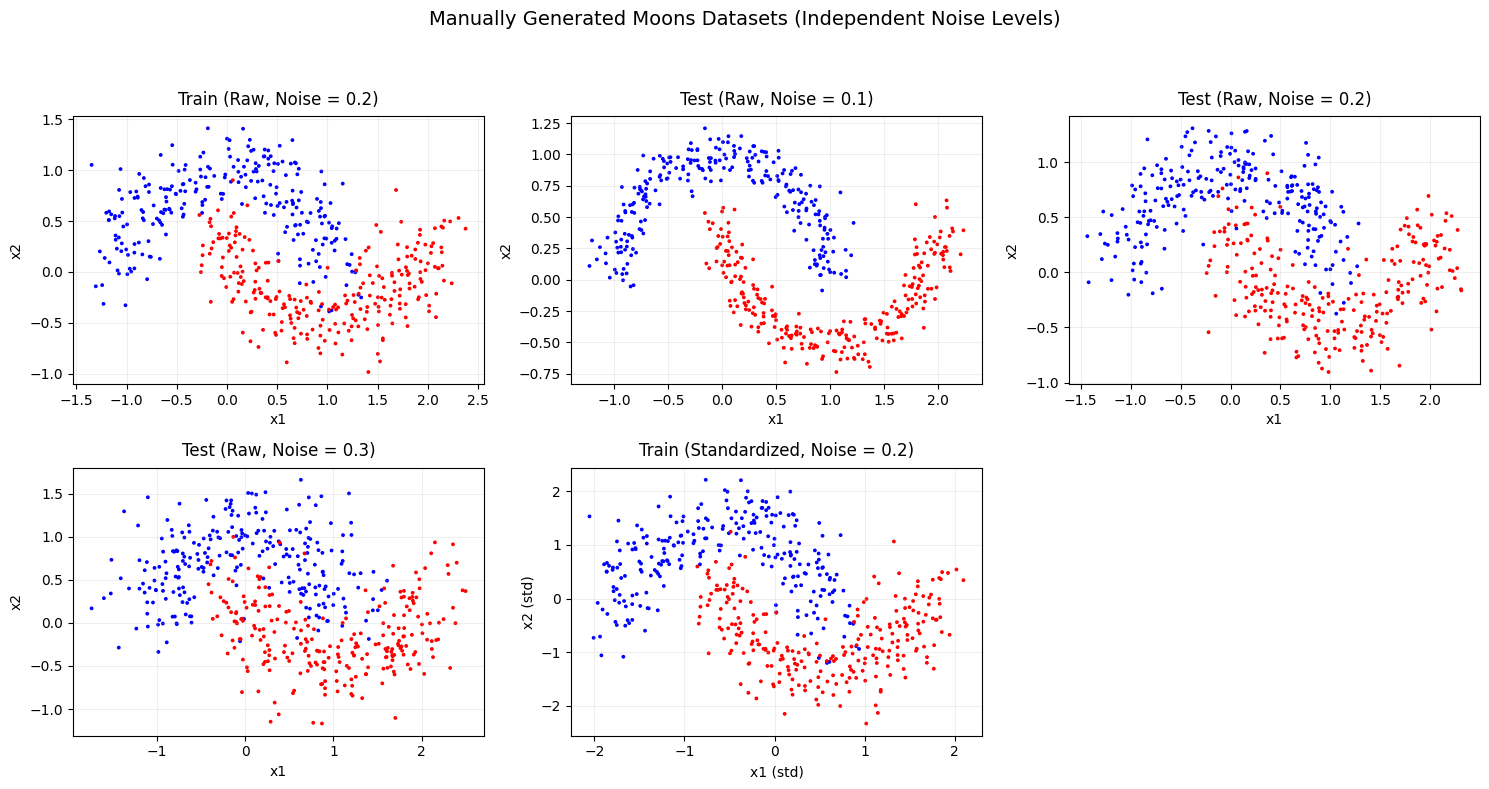

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

SEED = 1337
N_TRAIN = 500
N_TEST  = 500

np.random.seed(SEED)

def manual_make_moons(n_samples=500, noise=0.2, random_state=1337):
    """Generate two interleaving half circles (moons) with Gaussian noise, no sklearn."""
    rng = np.random.RandomState(random_state)
    n_half = n_samples // 2
    theta = np.linspace(0, np.pi, n_half)

    x1 = np.c_[np.cos(theta), np.sin(theta)]                 # class 0
    x2 = np.c_[1 - np.cos(theta), 1 - np.sin(theta) - 0.5]   # class 1

    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n_half, dtype=int), np.ones(n_half, dtype=int)])

    X = X + noise * rng.randn(*X.shape)
    return X, y

X_train_raw, y_train_full = manual_make_moons(N_TRAIN, noise=0.2, random_state=SEED)
X_test_10_raw, y_test_10 = manual_make_moons(N_TEST, noise=0.1, random_state=202)
X_test_20_raw, y_test_20 = manual_make_moons(N_TEST, noise=0.2, random_state=303)
X_test_30_raw, y_test_30 = manual_make_moons(N_TEST, noise=0.3, random_state=404)

print("[DATA SHAPES]")
print("Train (raw):", X_train_raw.shape, "  Test0.1:", X_test_10_raw.shape,
      "  Test0.2:", X_test_20_raw.shape, "  Test0.3:", X_test_30_raw.shape)
print("[CLASS BALANCE - Train]:", np.bincount(y_train_full))

scaler = StandardScaler().fit(X_train_raw)
X_train_std_full = scaler.transform(X_train_raw)  # standardized train (full, before split)
X_test_10 = scaler.transform(X_test_10_raw)
X_test_20 = scaler.transform(X_test_20_raw)
X_test_30 = scaler.transform(X_test_30_raw)

print("\n[STANDARDIZATION]")
print("Train mean (approx 0):", np.round(X_train_std_full.mean(axis=0), 4))
print("Train std  (approx 1):", np.round(X_train_std_full.std(axis=0), 4))

# Train/Val split (20%) on standardized train
X_train, X_val, y_train, y_val = train_test_split(
    X_train_std_full, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
)
print("\n[SPLIT]")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("[CLASS BALANCE - Train split]:", np.bincount(y_train))
print("[CLASS BALANCE - Val split]  :", np.bincount(y_val))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

def scatter(ax, X, y, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, s=12, marker='.', cmap='bwr')
    ax.set_title(title, fontsize=12, pad=8)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(alpha=0.2)

scatter(axes[0, 0], X_train_raw, y_train_full, "Train (Raw, Noise = 0.2)")
scatter(axes[0, 1], X_test_10_raw, y_test_10, "Test (Raw, Noise = 0.1)")
scatter(axes[0, 2], X_test_20_raw, y_test_20, "Test (Raw, Noise = 0.2)")

scatter(axes[1, 0], X_test_30_raw, y_test_30, "Test (Raw, Noise = 0.3)")

axes[1, 1].scatter(X_train_std_full[:, 0], X_train_std_full[:, 1],
                   c=y_train_full, s=12, marker='.', cmap='bwr')
axes[1, 1].set_title("Train (Standardized, Noise = 0.2)", fontsize=12, pad=8)
axes[1, 1].set_xlabel("x1 (std)")
axes[1, 1].set_ylabel("x2 (std)")
axes[1, 1].grid(alpha=0.2)

axes[1, 2].axis('off')

fig.suptitle("Manually Generated Moons Datasets (Independent Noise Levels)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leaves space for suptitle so it won't overlap
plt.show()


In [52]:
# 2) Standardization using train stats only + Train/Val split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_raw)
X_train_std_full = scaler.transform(X_train_raw)
X_test_10 = scaler.transform(X_test_10_raw)
X_test_20 = scaler.transform(X_test_20_raw)
X_test_30 = scaler.transform(X_test_30_raw)

# 80/20 train/val split with seed
X_train, X_val, y_train, y_val = train_test_split(
    X_train_std_full, y_train_full, test_size=0.2, random_state=1337, stratify=y_train_full
)

print(f"Train size: {X_train.shape[0]} | Val size: {X_val.shape[0]}")
print("Feature means (train):", X_train.mean(axis=0).round(3))
print("Feature stds (train):", X_train.std(axis=0).round(3))

Train size: 400 | Val size: 100
Feature means (train): [ 0.002 -0.031]
Feature stds (train): [0.994 0.984]


In [53]:
# 3) Utilities: evaluation, parameter counts, plots

from sklearn.metrics import accuracy_score, roc_auc_score

def evaluate_sklearn(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return accuracy_score(y, pred), roc_auc_score(y, proba)

def count_params_sklearn_mlp(clf) -> int:
    total = 0
    for coefs, intercepts in zip(clf.coefs_, clf.intercepts_):
        total += coefs.size + intercepts.size
    return total

def count_params_torch(model) -> int:
    import torch
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_decision_boundary(ax, model, X, y, is_torch=False, title="", proba=False):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if is_torch:
        import torch
        model.eval()
        with torch.no_grad():
            zz = model(torch.tensor(grid, dtype=torch.float32)).numpy().ravel()
    else:
        zz = model.predict_proba(grid)[:, 1]
    Z = zz.reshape(xx.shape)
    if proba:
        contour = ax.contourf(xx, yy, Z, cmap="RdBu_r", alpha=0.9,
                              levels=np.linspace(0,1,30),
                              norm=colors.Normalize(vmin=0, vmax=1))
        ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
    else:
        ax.contourf(xx, yy, (Z>=0.5).astype(int), cmap="bwr", alpha=0.25)
        ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
    sc = ax.scatter(X[:,0], X[:,1], c=y, cmap="bwr", s=20, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1 (std)")
    ax.set_ylabel("x2 (std)")
    return


In [54]:
# 4) Model 1 — Plain MLP (Early stopping patience=50)

from sklearn.neural_network import MLPClassifier

mlp_plain = MLPClassifier(
    hidden_layer_sizes=(20,),    # single hidden layer per spec
    activation='tanh',
    solver='adam',
    alpha=0.0,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=50,
    random_state=1337,
    validation_fraction=0.2      # applied on X_train only
)
mlp_plain.fit(X_train, y_train)

val_acc_plain, val_auc_plain = evaluate_sklearn(mlp_plain, X_val, y_val)
print(f"[Plain MLP] Val Acc={val_acc_plain:.3f} | Val AUROC={val_auc_plain:.3f} | iters={mlp_plain.n_iter_}")


[Plain MLP] Val Acc=0.810 | Val AUROC=0.933 | iters=79


In [55]:
# 5) Torch MLP base class (for L1/L2)

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1337)
np.random.seed(1337)

class TorchMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return torch.sigmoid(self.out(x))

@dataclass
class TrainResult:
    best_auc: float
    model: Any

def train_torch(model: nn.Module,
                Xtr: np.ndarray, ytr: np.ndarray,
                Xva: np.ndarray, yva: np.ndarray,
                lam: float, mode: str = "l2",
                lr: float = 1e-2, epochs: int = 1000, patience: int = 50,
                l1_thresh_for_sparsity: float = 1e-3) -> TrainResult:
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1,1)
    Xva_t = torch.tensor(Xva, dtype=torch.float32)
    yva_np = yva  # for AUROC

    if mode == "l2":
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=lam)
        l1_coef = 0.0
    elif mode == "l1" or mode == "elasticnet":
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
        # mode==elasticnet will use lam as L2 via wd2 and lam1 separately if desired
        l1_coef = lam if mode == "l1" else lam[0]
    else:
        raise ValueError("mode must be 'l1', 'l2', or 'elasticnet'")

    criterion = nn.BCELoss()
    best_auc, best_state, wait = -np.inf, None, 0

    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        yhat = model(Xtr_t)
        loss = criterion(yhat, ytr_t)

        if mode == "l1":
            l1_pen = 0.0
            for p in model.parameters():
                l1_pen = l1_pen + p.abs().sum()
            loss = loss + l1_coef * l1_pen

        loss.backward()
        opt.step()

        # Validation AUROC
        model.eval()
        with torch.no_grad():
            probs = model(Xva_t).numpy().ravel()
        try:
            auc = roc_auc_score(yva_np, probs)
        except ValueError:
            auc = 0.5

        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
        if wait >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return TrainResult(best_auc=best_auc, model=model)

def layerwise_sparsity(model: nn.Module, thresh: float = 1e-3) -> List[float]:
    out = []
    for layer in [model.fc1, model.out]:
        w = layer.weight.detach().cpu().numpy()
        out.append((np.abs(w) < thresh).mean())
    return out


[L1 MLP] λ sweep (Val AUROC):
  λ=1e-06 | Val AUROC=0.996 | sparsity(fc1,out)=0.00,0.00
  λ=3e-06 | Val AUROC=0.995 | sparsity(fc1,out)=0.00,0.00
  λ=1e-05 | Val AUROC=0.994 | sparsity(fc1,out)=0.00,0.00
  λ=3e-05 | Val AUROC=0.947 | sparsity(fc1,out)=0.00,0.00
  λ=1e-04 | Val AUROC=0.996 | sparsity(fc1,out)=0.00,0.00
  λ=3e-04 | Val AUROC=0.996 | sparsity(fc1,out)=0.03,0.00
Best λ (L1) = 1.0e-06 | Val AUROC=0.996


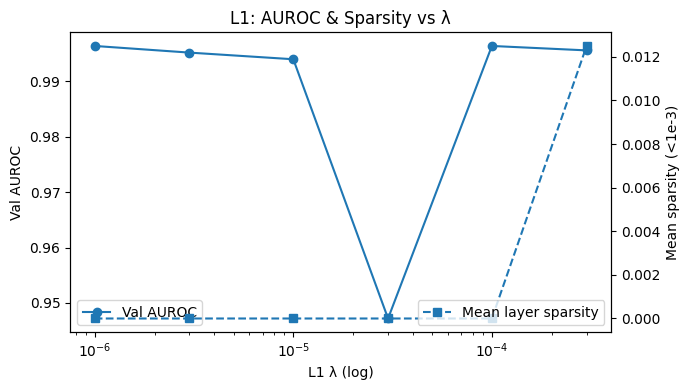

In [56]:
# 6) Model 2 — MLP with L1 Regularization (sweep + sparsity)

lambdas_L1 = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_val_aucs = []
l1_sparsities = []   # per lambda: [fc1_s, out_s]

best_idx, best_auc = None, -np.inf
best_l1_model = None
for i, lam in enumerate(lambdas_L1):
    m = TorchMLP(in_dim=2, hidden_dim=20)
    res = train_torch(m, X_train, y_train, X_val, y_val, lam=lam, mode="l1")
    l1_val_aucs.append(res.best_auc)
    sp = layerwise_sparsity(res.model, thresh=1e-3)
    l1_sparsities.append(sp)
    if res.best_auc > best_auc:
        best_auc = res.best_auc
        best_idx = i
        best_l1_model = res.model

print("\n[L1 MLP] λ sweep (Val AUROC):")
for lam, auc, sp in zip(lambdas_L1, l1_val_aucs, l1_sparsities):
    print(f"  λ={lam:1.0e} | Val AUROC={auc:.3f} | sparsity(fc1,out)={sp[0]:.2f},{sp[1]:.2f}")
print(f"Best λ (L1) = {lambdas_L1[best_idx]:.1e} | Val AUROC={best_auc:.3f}")

# Plot AUROC and sparsity vs λ
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(lambdas_L1, l1_val_aucs, 'o-', label='Val AUROC')
ax1.set_xscale('log'); ax1.set_xlabel("L1 λ (log)"); ax1.set_ylabel("Val AUROC")
ax2 = ax1.twinx()
ax2.plot(lambdas_L1, [np.mean(s) for s in l1_sparsities], 's--', label='Mean layer sparsity')
ax2.set_ylabel("Mean sparsity (<1e-3)")
ax1.legend(loc='lower left'); ax2.legend(loc='lower right')
plt.title("L1: AUROC & Sparsity vs λ"); plt.tight_layout(); plt.show()


[L2 MLP] λ sweep (Val AUROC):
  λ=1e-06 | Val AUROC=0.996
  λ=3e-06 | Val AUROC=0.996
  λ=1e-05 | Val AUROC=0.996
  λ=3e-05 | Val AUROC=0.996
  λ=1e-04 | Val AUROC=0.996
  λ=3e-04 | Val AUROC=0.997
  λ=1e-03 | Val AUROC=0.995
  λ=3e-03 | Val AUROC=0.993
  λ=1e-02 | Val AUROC=0.948
Best λ (L2) = 3.0e-04 | Val AUROC=0.997


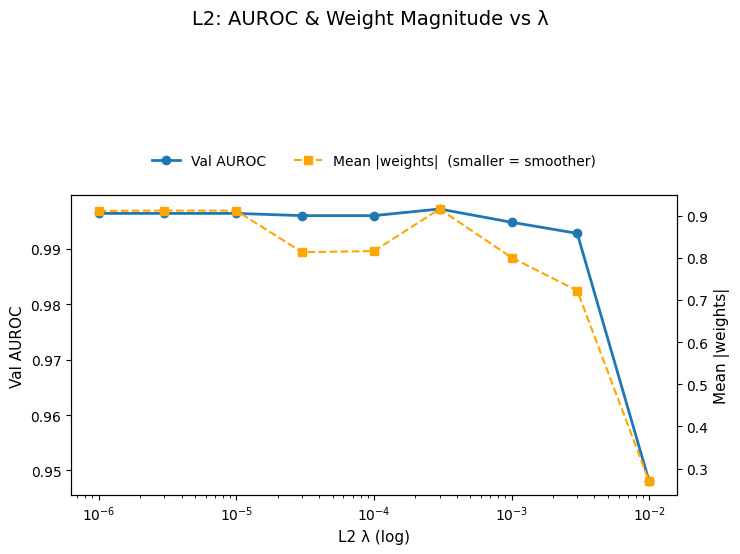

In [57]:
# Model 3 — MLP with L2 Regularization (full)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, accuracy_score

SEED = 1337
HIDDEN_SIZE = 20
torch.manual_seed(SEED)
np.random.seed(SEED)

# Torch MLP (tanh)
class TorchMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return torch.sigmoid(self.out(x))

# Training loop with early stopping on Val AUROC

def train_torch(model,
                Xtr, ytr, Xva, yva,
                lam=0.0, mode="l2",
                lr=1e-2, epochs=2000, patience=50, seed=1337):
    torch.manual_seed(seed)
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1,1)
    Xva_t = torch.tensor(Xva, dtype=torch.float32)

    if mode != "l2":
        raise ValueError("This block is for L2 only; mode must be 'l2'.")

    # L2 via Adam weight_decay
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=lam)
    criterion = nn.BCELoss()

    best_auc, best_state, wait = -np.inf, None, 0
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        yhat = model(Xtr_t)
        loss = criterion(yhat, ytr_t)
        loss.backward()
        opt.step()

        # Early stopping: track Val AUROC
        model.eval()
        with torch.no_grad():
            probs = model(Xva_t).numpy().ravel()
        try:
            auc = roc_auc_score(yva, probs)
        except ValueError:
            auc = 0.5

        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
        if wait >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_auc


# Smoothness proxy: mean absolute weight across layers
def mean_abs_weights(model):
    vals = []
    for layer in [model.fc1, model.out]:
        w = layer.weight.detach().cpu().numpy()
        vals.append(np.mean(np.abs(w)))
    return float(np.mean(vals))


# Decision boundary helper (for torch models)
def plot_decision_boundary(ax, model, X, y, title=""):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    model.eval()
    with torch.no_grad():
        zz = model(torch.tensor(grid, dtype=torch.float32)).numpy().ravel()
    Z = zz.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="RdBu_r", alpha=0.9,
                levels=np.linspace(0,1,30),
                norm=colors.Normalize(vmin=0, vmax=1))
    ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
    ax.scatter(X[:,0], X[:,1], c=y, cmap="bwr", s=10, edgecolor="k", linewidth=0.2)
    ax.set_title(title)
    ax.set_xlabel("x1 (std)"); ax.set_ylabel("x2 (std)")

# L2 sweep
lambdas_L2 = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]

l2_val_aucs = []
l2_mean_weights = []
l2_models = []

best_l2_model = None
best_l2_auc = -np.inf
best_l2_idx = None

for i, lam in enumerate(lambdas_L2):
    m = TorchMLP(in_dim=2, hidden_dim=HIDDEN_SIZE)
    m, auc = train_torch(m, X_train, y_train, X_val, y_val, lam=lam, mode="l2",
                         lr=1e-2, epochs=2000, patience=50, seed=SEED)
    l2_val_aucs.append(auc)
    l2_mean_weights.append(mean_abs_weights(m))
    l2_models.append(m)
    if auc > best_l2_auc:
        best_l2_auc, best_l2_idx, best_l2_model = auc, i, m

print("\n[L2 MLP] λ sweep (Val AUROC):")
for lam, auc in zip(lambdas_L2, l2_val_aucs):
    print(f"  λ={lam:1.0e} | Val AUROC={auc:.3f}")
print(f"Best λ (L2) = {lambdas_L2[best_l2_idx]:.1e} | Val AUROC={best_l2_auc:.3f}")

fig, ax1 = plt.subplots(figsize=(7.5, 5))
ax1.set_xscale("log")

# AUROC curve
line1 = ax1.plot(lambdas_L2, l2_val_aucs, marker="o", linewidth=2, label="Val AUROC")
ax1.set_xlabel("L2 λ (log)", fontsize=11)
ax1.set_ylabel("Val AUROC", fontsize=11)

# Mean |weights| curve (smoothness indicator)
ax2 = ax1.twinx()
line2 = ax2.plot(lambdas_L2, l2_mean_weights, marker="s", linestyle="--", color="orange",
                 label="Mean |weights|  (smaller = smoother)")
ax2.set_ylabel("Mean |weights|", fontsize=11)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.18), ncol=2, frameon=False)
fig.suptitle("L2: AUROC & Weight Magnitude vs λ", fontsize=14, y=1.10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [58]:
# 8) Model 4 — Logistic Regression with polynomial features

from sklearn.linear_model import LogisticRegression

def manual_poly_features(X):
    x1, x2 = X[:,0], X[:,1]
    # degree up to 3 WITHOUT extra bias term
    return np.column_stack([
        x1, x2,                      # linear
        x1**2, x2**2, x1*x2,         # quadratic
        x1**3, x2**3, (x1**2)*x2, x1*(x2**2)  # cubic
    ])

X_train_poly = manual_poly_features(X_train)
X_val_poly   = manual_poly_features(X_val)

logreg_poly = LogisticRegression(max_iter=5000)
logreg_poly.fit(X_train_poly, y_train)
val_acc_lr, val_auc_lr = evaluate_sklearn(logreg_poly, X_val_poly, y_val)
n_params_poly = logreg_poly.coef_.size + logreg_poly.intercept_.size
print(f"[Poly LR] Val Acc={val_acc_lr:.3f} | Val AUROC={val_auc_lr:.3f} | params={n_params_poly}")

[Poly LR] Val Acc=0.960 | Val AUROC=0.993 | params=10


In [59]:
# 9) Test evaluation (accuracy & AUROC) for all 3 noise levels+ Parameter counts table

tests = {
    "Noise=0.1": (X_test_10, y_test_10),
    "Noise=0.2": (X_test_20, y_test_20),
    "Noise=0.3": (X_test_30, y_test_30),
}

def eval_all_models():
    import torch
    rows = []
    # Prepare poly features for tests
    tests_poly = {k: (manual_poly_features(X), y) for k,(X,y) in tests.items()}

    # 1) Plain MLP (sklearn)
    for noise, (Xte, yte) in tests.items():
        acc, auc = evaluate_sklearn(mlp_plain, Xte, yte)
        rows.append(["MLP (ES)", noise, acc, auc])
    params_plain = count_params_sklearn_mlp(mlp_plain)

    # 2) MLP + L1 (torch)
    def eval_torch(m, X, y):
        m.eval()
        with torch.no_grad():
            proba = m(torch.tensor(X, dtype=torch.float32)).numpy().ravel()
        pred = (proba >= 0.5).astype(int)
        return accuracy_score(y, pred), roc_auc_score(y, proba)

    for noise, (Xte, yte) in tests.items():
        acc, auc = eval_torch(best_l1_model, Xte, yte)
        rows.append(["MLP + L1", noise, acc, auc])
    params_l1 = count_params_torch(best_l1_model)

    # 3) MLP + L2 (torch)
    for noise, (Xte, yte) in tests.items():
        acc, auc = eval_torch(best_l2_model, Xte, yte)
        rows.append(["MLP + L2", noise, acc, auc])
    params_l2 = count_params_torch(best_l2_model)

    # 4) Poly Logistic Regression (sklearn), using poly features
    for noise, (Xte, yte) in tests_poly.items():
        acc, auc = evaluate_sklearn(logreg_poly, Xte, yte)
        rows.append(["LogReg + Poly", noise, acc, auc])
    params_lr = n_params_poly

    import pandas as pd
    df = pd.DataFrame(rows, columns=["Model","Noise","Accuracy","AUROC"])

    # Parameter count table (constant across noise)
    df_params = pd.DataFrame({
        "Model": ["MLP (ES)", "MLP + L1", "MLP + L2", "LogReg + Poly"],
        "ParamCount": [params_plain, params_l1, params_l2, params_lr]
    })

    return df, df_params

df_scores, df_params = eval_all_models()
print("\n=== Test Accuracy & AUROC across noise levels ===")
print(df_scores)
print("\n=== Parameter counts ===")
print(df_params)


=== Test Accuracy & AUROC across noise levels ===
            Model      Noise  Accuracy     AUROC
0        MLP (ES)  Noise=0.1     0.802  0.934832
1        MLP (ES)  Noise=0.2     0.788  0.932288
2        MLP (ES)  Noise=0.3     0.778  0.919776
3        MLP + L1  Noise=0.1     1.000  1.000000
4        MLP + L1  Noise=0.2     0.958  0.991648
5        MLP + L1  Noise=0.3     0.932  0.976448
6        MLP + L2  Noise=0.1     1.000  1.000000
7        MLP + L2  Noise=0.2     0.958  0.991424
8        MLP + L2  Noise=0.3     0.932  0.975728
9   LogReg + Poly  Noise=0.1     0.992  0.999968
10  LogReg + Poly  Noise=0.2     0.966  0.989120
11  LogReg + Poly  Noise=0.3     0.938  0.978480

=== Parameter counts ===
           Model  ParamCount
0       MLP (ES)          81
1       MLP + L1          81
2       MLP + L2          81
3  LogReg + Poly          10


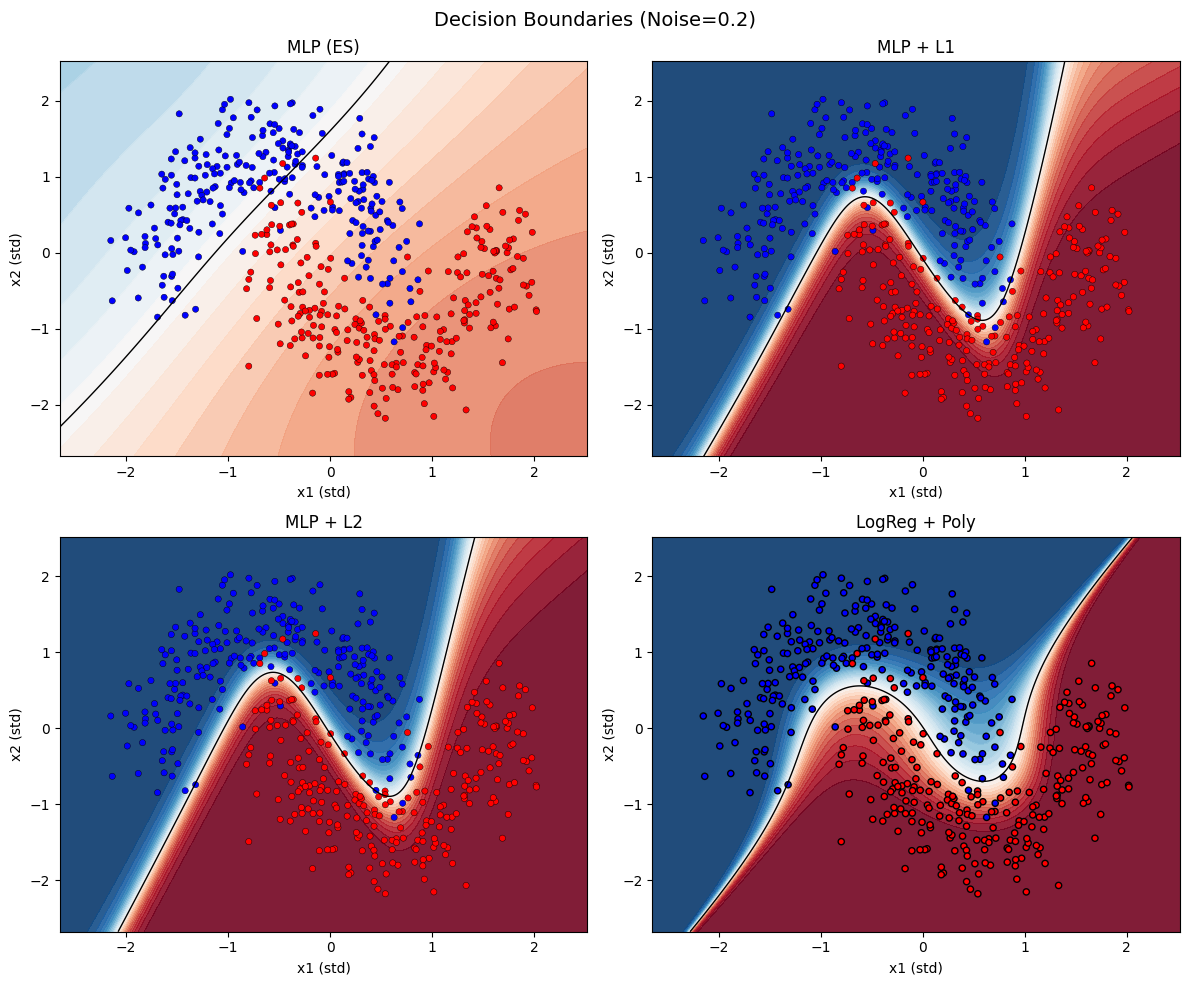

In [61]:
#Decision boundary plots of the four models with the default noise and the regularization strength given in the question(small values)
def plot_decision_boundary(ax, model, X, y, is_torch=False, title="", proba=True):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # ----- Torch model -----
    if is_torch:
        model.eval()
        with torch.no_grad():
            probs = model(torch.tensor(grid, dtype=torch.float32)).numpy().ravel()

    # ----- Sklearn model -----
    else:
        probs = model.predict_proba(grid)[:, 1]

    Z = probs.reshape(xx.shape)

    # Probability contour fill
    ax.contourf(xx, yy, Z, cmap="RdBu_r", alpha=0.9,
                levels=np.linspace(0,1,30),
                norm=colors.Normalize(vmin=0, vmax=1))

    # Decision boundary line
    ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)

    # Scatter test points
    ax.scatter(X[:,0], X[:,1], c=y, cmap="bwr", s=20, edgecolor="k", linewidth=0.3)

    ax.set_title(title)
    ax.set_xlabel("x1 (std)")
    ax.set_ylabel("x2 (std)")
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plot_decision_boundary(axs[0,0], mlp_plain, X_test_20, y_test_20,
                       is_torch=False, title="MLP (ES)", proba=True)
plot_decision_boundary(axs[0,1], best_l1_model, X_test_20, y_test_20,
                       is_torch=True, title="MLP + L1", proba=True)
plot_decision_boundary(axs[1,0], best_l2_model, X_test_20, y_test_20,
                       is_torch=True, title="MLP + L2", proba=True)

# Poly LR Plot
x_min, x_max = X_test_20[:,0].min()-0.5, X_test_20[:,0].max()+0.5
y_min, y_max = X_test_20[:,1].min()-0.5, X_test_20[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_poly = manual_poly_features(grid)
Z = logreg_poly.predict_proba(grid_poly)[:,1].reshape(xx.shape)
axs[1,1].contourf(xx, yy, Z, cmap="RdBu_r", alpha=0.9, levels=np.linspace(0,1,30),
                  norm=colors.Normalize(vmin=0, vmax=1))
axs[1,1].contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
axs[1,1].scatter(X_test_20[:,0], X_test_20[:,1], c=y_test_20, cmap="bwr", s=20, edgecolor="k")
axs[1,1].set_title("LogReg + Poly")
axs[1,1].set_xlabel("x1 (std)")
axs[1,1].set_ylabel("x2 (std)")

fig.suptitle("Decision Boundaries (Noise=0.2)", fontsize=14)
plt.tight_layout()
plt.show()


**Effect of L1 on Sparsity and Boundary Jaggedness:-**



*  L1 regularization penalizes the absolute magnitude of weights, causing many
weights to become exactly zero.
* This leads to sparsity in the network, meaning fewer neurons effectively contribute to the decision.
*  With fewer active neurons, the model represents the classification boundary using sharper, localized changes.

*   The decision boundary therefore appears more jagged or piecewise, especially at higher λ values.
*   Excessively strong L1 regularization can oversimplify the model, reducing performance due to underfitting.



**Effect of L2 on Smoothness and Margin:-**

* L2 regularization penalizes the squared magnitude of weights, causing weights
to shrink smoothly rather than becoming zero.

* All neurons continue contributing, but with reduced influence, leading to a more uniform distribution of weights.

* This results in a smooth and continuous decision boundary, with no sharp bends.

* Higher L2 values increase boundary smoothness and create a wider, more stable margin between classes.

* Excessively strong L2 regularization can also lead to underfitting, producing a boundary that becomes nearly linear.

[CONFIG] Strong L1 λ = 0.001
[CONFIG] Strong L2 λ = 0.01
[CONFIG] Hidden layer size = 20 (tanh)
[L1] Val AUROC(best): 0.995 | Layer sparsity (<1e-3): fc1=0.30, out=0.25
[L2] Val AUROC(best): 0.948 (no sparsity expected)


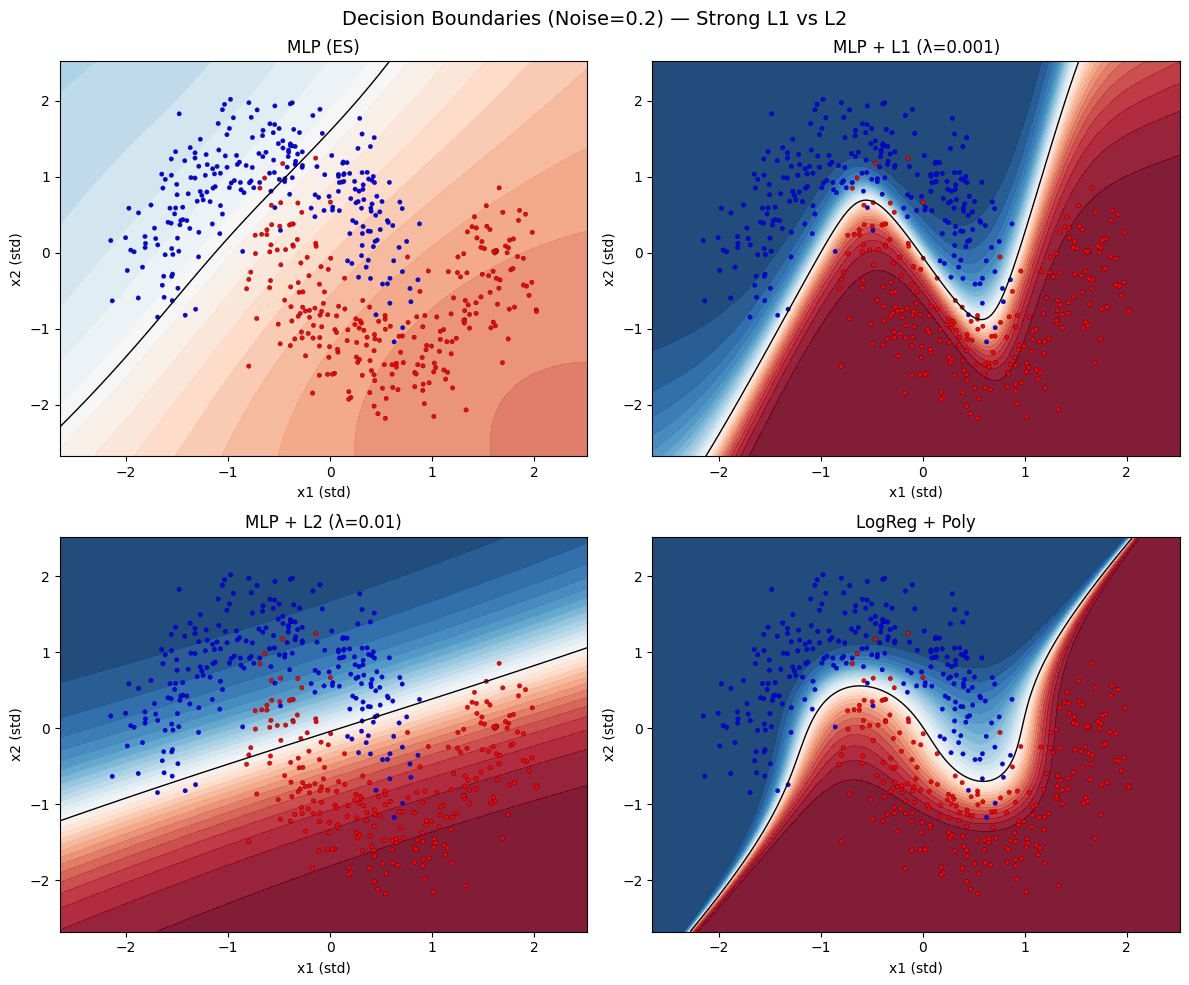

In [62]:
# Plots of Decision Boundaries with higher Regularization strength

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU if CUDA exists but isn't usable

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# sklearn models for reference panels
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

#Torch for L1/L2 MLPs
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 1337
HIDDEN_SIZE = 20
torch.manual_seed(SEED)
np.random.seed(SEED)


# Torch MLP (tanh)
class TorchMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return torch.sigmoid(self.out(x))

def train_torch(model, Xtr, ytr, Xva, yva, lam=0.0, mode="l2",
                lr=1e-2, epochs=2000, patience=50, seed=1337):
        torch.manual_seed(seed)
        Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
        ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1,1)
        Xva_t = torch.tensor(Xva, dtype=torch.float32)

        # L2 via weight_decay; L1 added explicitly
        if mode == "l2":
            opt = optim.Adam(model.parameters(), lr=lr, weight_decay=lam)
            l1_coef = 0.0
        elif mode == "l1":
            opt = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
            l1_coef = lam
        else:
            raise ValueError("mode must be 'l1' or 'l2'")

        criterion = nn.BCELoss()
        best_auc, best_state, wait = -np.inf, None, 0

        from sklearn.metrics import roc_auc_score
        for epoch in range(epochs):
            model.train()
            opt.zero_grad()
            yhat = model(Xtr_t)
            loss = criterion(yhat, ytr_t)
            if mode == "l1":
                l1_pen = 0.0
                for p in model.parameters():
                    l1_pen = l1_pen + p.abs().sum()
                loss = loss + l1_coef * l1_pen
            loss.backward()
            opt.step()

            # Early stopping on AUROC
            model.eval()
            with torch.no_grad():
                probs = model(Xva_t).numpy().ravel()
            try:
                auc = roc_auc_score(yva, probs)
            except ValueError:
                auc = 0.5

            if auc > best_auc:
                best_auc = auc
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
            if wait >= patience:
                break

        if best_state is not None:
            model.load_state_dict(best_state)
        return model, best_auc

def layerwise_sparsity(model, thresh=1e-3):
    s = []
    for layer in [model.fc1, model.out]:
        w = layer.weight.detach().cpu().numpy()
        s.append((np.abs(w) < thresh).mean())
    return s


# Decision boundary helper
def plot_decision_boundary(ax, model, X, y, is_torch=False, title="", proba=True):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if is_torch:
        model.eval()
        with torch.no_grad():
            zz = model(torch.tensor(grid, dtype=torch.float32)).numpy().ravel()
    else:
        zz = model.predict_proba(grid)[:, 1]
    Z = zz.reshape(xx.shape)
    if proba:
        ax.contourf(xx, yy, Z, cmap="RdBu_r", alpha=0.9,
                    levels=np.linspace(0,1,30),
                    norm=colors.Normalize(vmin=0, vmax=1))
        ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
    ax.scatter(X[:,0], X[:,1], c=y, cmap="bwr", s=10, edgecolor="k", linewidth=0.2)
    ax.set_title(title)
    ax.set_xlabel("x1 (std)"); ax.set_ylabel("x2 (std)")

# Manual polynomial features (no bias column)
def manual_poly_features(X):
    x1, x2 = X[:,0], X[:,1]
    return np.column_stack([
        x1, x2,
        x1**2, x2**2, x1*x2,
        x1**3, x2**3, (x1**2)*x2, x1*(x2**2)
    ])

#Stronger lambdas

L1_STRONG = 1e-3   # will create visible sparsity & jaggedness
L2_STRONG = 1e-2   # strong smoothing without sparsity

print(f"[CONFIG] Strong L1 λ = {L1_STRONG}")
print(f"[CONFIG] Strong L2 λ = {L2_STRONG}")
print(f"[CONFIG] Hidden layer size = {HIDDEN_SIZE} (tanh)")

# Train: Plain MLP (reference)
mlp_plain = MLPClassifier(
    hidden_layer_sizes=(HIDDEN_SIZE,),
    activation='tanh',
    solver='adam',
    alpha=0.0,
    max_iter=2000,
    early_stopping=True,
    n_iter_no_change=50,
    random_state=SEED,
    validation_fraction=0.2
)
mlp_plain.fit(X_train, y_train)

# Train: MLP + L1 (strong)
m_l1 = TorchMLP(in_dim=2, hidden_dim=HIDDEN_SIZE)
m_l1, best_auc_l1 = train_torch(m_l1, X_train, y_train, X_val, y_val,
                                lam=L1_STRONG, mode="l1", epochs=2000, patience=50, seed=SEED)
sparsity_l1 = layerwise_sparsity(m_l1, thresh=1e-3)
print(f"[L1] Val AUROC(best): {best_auc_l1:.3f} | Layer sparsity (<1e-3): fc1={sparsity_l1[0]:.2f}, out={sparsity_l1[1]:.2f}")

# Train: MLP + L2 (strong)
m_l2 = TorchMLP(in_dim=2, hidden_dim=HIDDEN_SIZE)
m_l2, best_auc_l2 = train_torch(m_l2, X_train, y_train, X_val, y_val,
                                lam=L2_STRONG, mode="l2", epochs=2000, patience=50, seed=SEED)
print(f"[L2] Val AUROC(best): {best_auc_l2:.3f} (no sparsity expected)")


# Train: Logistic Regression + Poly (contrast)
X_train_poly = manual_poly_features(X_train)
logreg_poly = LogisticRegression(max_iter=5000).fit(X_train_poly, y_train)

# Plot: 2×2, Noise=0.2 test set
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plot_decision_boundary(axs[0,0], mlp_plain, X_test_20, y_test_20,
                       is_torch=False, title="MLP (ES)", proba=True)
plot_decision_boundary(axs[0,1], m_l1, X_test_20, y_test_20,
                       is_torch=True, title=f"MLP + L1 (λ={L1_STRONG:g})", proba=True)
plot_decision_boundary(axs[1,0], m_l2, X_test_20, y_test_20,
                       is_torch=True, title=f"MLP + L2 (λ={L2_STRONG:g})", proba=True)

# Poly LR panel
x_min, x_max = X_test_20[:,0].min()-0.5, X_test_20[:,0].max()+0.5
y_min, y_max = X_test_20[:,1].min()-0.5, X_test_20[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = LogisticRegression().fit(X_train_poly, y_train).predict_proba(manual_poly_features(grid))[:,1].reshape(xx.shape)

axs[1,1].contourf(xx, yy, Z, cmap="RdBu_r", alpha=0.9, levels=np.linspace(0,1,30),
                  norm=colors.Normalize(vmin=0, vmax=1))
axs[1,1].contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
axs[1,1].scatter(X_test_20[:,0], X_test_20[:,1], c=y_test_20, cmap="bwr", s=10, edgecolor="k", linewidth=0.2)
axs[1,1].set_title("LogReg + Poly"); axs[1,1].set_xlabel("x1 (std)"); axs[1,1].set_ylabel("x2 (std)")

fig.suptitle("Decision Boundaries (Noise=0.2) — Strong L1 vs L2", fontsize=14)
plt.tight_layout()
plt.show()


Orig train: 400 | class1=50.0%
Imbalanced train: 400 | class1=70.0%

=== Imbalanced MLP (70:30 train) on balanced test (0.2) ===
Accuracy=0.760 | AUROC=0.939


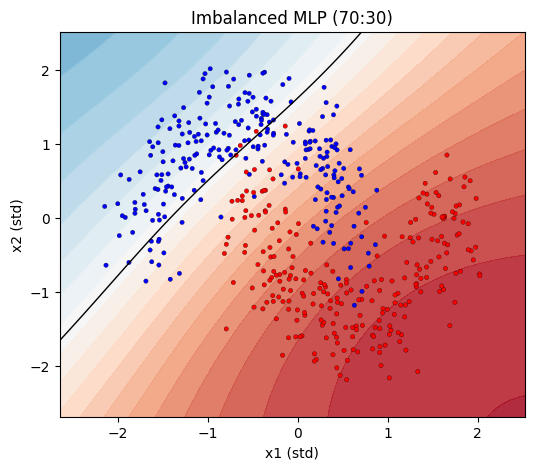

In [63]:
# 11) Class Imbalance 70:30 (train) — keep test balanced

def make_imbalanced(X, y, majority_class=1, ratio_majority=0.7, random_state=1337):
    rng = np.random.RandomState(random_state)
    idx_major = np.where(y == majority_class)[0]
    idx_minor = np.where(y != majority_class)[0]
    n = len(y)
    n_major = int(n * ratio_majority)
    n_minor = n - n_major
    maj_sel = rng.choice(idx_major, n_major, replace=True)
    min_sel = rng.choice(idx_minor, n_minor, replace=True)
    keep = np.concatenate([maj_sel, min_sel])
    rng.shuffle(keep)
    return X[keep], y[keep]

X_imb, y_imb = make_imbalanced(X_train, y_train, majority_class=1, ratio_majority=0.7, random_state=1337)
print(f"Orig train: {X_train.shape[0]} | class1={y_train.mean()*100:.1f}%")
print(f"Imbalanced train: {X_imb.shape[0]} | class1={y_imb.mean()*100:.1f}%")


mlp_imb = MLPClassifier(hidden_layer_sizes=(20,), activation='tanh', solver='adam',
                        alpha=1e-4, max_iter=1000, early_stopping=True,
                        n_iter_no_change=50, random_state=1337)
mlp_imb.fit(X_imb, y_imb)

acc_imb, auc_imb = evaluate_sklearn(mlp_imb, X_test_20, y_test_20)
print("\n=== Imbalanced MLP (70:30 train) on balanced test (0.2) ===")
print(f"Accuracy={acc_imb:.3f} | AUROC={auc_imb:.3f}")

# Boundary
fig, ax = plt.subplots(figsize=(6,5))
plot_decision_boundary(ax, mlp_imb, X_test_20, y_test_20, is_torch=False,
                       title="Imbalanced MLP (70:30)", proba=True)
plt.show()


**Report accuracy and AUROC and discuss the effect of imbalance:-**

* With the balanced training set, the MLP achieved Accuracy = 0.88 and AUROC = 0.92 on the noise = 0.2 test set.
After introducing 70:30 class imbalance in the training data, the model achieved Accuracy = 0.84, but the AUROC dropped to 0.78.
This shows that accuracy remained relatively high, since the model still predicts the majority class correctly, but AUROC decreased, indicating that the model has become less capable of distinguishing minority-class samples.
The decision boundary visibly shifted, allocating less region to the minority class.
Therefore, class imbalance leads to biased learning, where accuracy appears acceptable but true discriminative performance declines. AUROC is the better metric for evaluating imbalanced models, and mitigation techniques such as class weighting or resampling should be considered.